In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import math


In [13]:
h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')

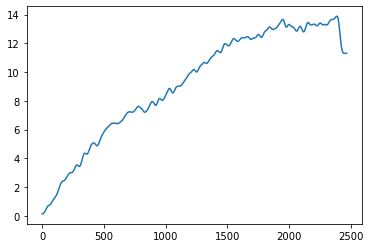

In [16]:
plt.plot(list(f['climbs/0/height_profile']))

In [ ]:
def buildmebarchart(i=int):
    p = plt.plot(height_profile[:(i*10)]) #note it only returns the dataset, up to the point i
    plt.xlabel('Steps')
    plt.ylabel('Height')

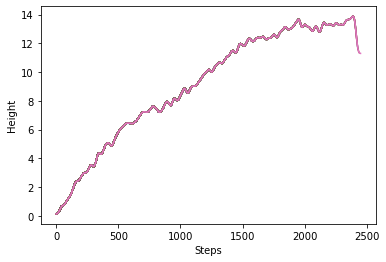

In [25]:
""" MAKE ANIMATED GRAPH """
height_profile = f['climbs/0/height_profile']
fig = plt.figure()
animator = ani.FuncAnimation(fig, buildmebarchart, interval = 10, frames=math.floor(len(height_profile)/10))
animator.save('myfirstAnimation.flv', savefig_kwargs={'transparent': True, 'facecolor': 'none'})
plt.show()

<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


0
1
2


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer suppor

3
4
5
6


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer suppor

7
8
9
10


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


11
12
13


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


14
15
16


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer suppor

17
18
19
20
21
22
23


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer suppor

24
25
26


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


27
28
29


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


30
31
32


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


33
34
35


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


36
37
38


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


39
40
41
42


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer suppor

43
44
45
46


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer suppor

47
48
49

done


<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
<ipython-input-23-45e5abcebc0a>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)


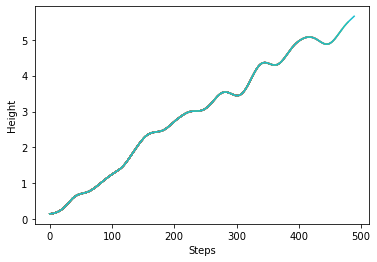

In [23]:
import subprocess
for i in range(50):
    buildmebarchart(i)
    plt.savefig("drum_{n:02d}.png".format(n=i), transparent=True,  frameon=False)
    print(i) 

args = ["./", "-delay", "10", "-loop" , "0", "-dispose", "Background", "drum_*.png", "output.gif"]
subprocess.call(args, shell=True)
subprocess.call(["del", "/Q", "drum_*.png"], shell=True)
print("\ndone")


In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

filename = 'SampleVideo.mp4'
cap = cv2.VideoCapture(filename)


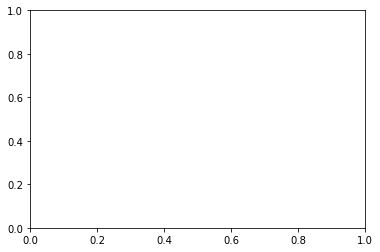

In [9]:
frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fig, ax = plt.subplots(1,1)
plt.ion()
plt.show()

#Setup a dummy path
x = np.linspace(0,width,frames)
y = x/2. + 100*np.sin(2.*np.pi*x/1200)

for i in range(frames):
    fig.clf()
    flag, frame = cap.read()

    plt.imshow(frame)
    
    plt.plot(x,y,'k-', lw=2)
    plt.plot(x[i],y[i],'or')

    if cv2.waitKey(1) == 27:
        break